In [1]:
from google.colab import drive
drive.mount('/content/drive')
ROOT='''/content/drive/MyDrive/Colab Notebooks/googledrive/wordAssociation'''

Mounted at /content/drive


In [2]:
!pip install pingouin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 4.2 MB/s eta 0:00:00


In [3]:
import json
import matplotlib.pyplot as plt
import numpy as np
from colour import Color
import seaborn as sn
import pandas as pd
from matplotlib.patches import Rectangle

import pingouin as pg
from scipy import stats
import random
import math
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import multipletests

XIAOROOT='/home/liuxiao/TuringGithub/XiaoData/Rebuttal_Figures/R3.1-Feedback-Zeroshot-eps/Task2-Word/'

def outputIconForStats(pval):
    if pval <= 0.05:
        icon = '*'
    else:
        icon = ' '
    return icon

def ConvertDictToDataFrame(datadict):
    #data = {'col_1': [3, 2, 1, 0], 'col_2': ['a', 'b', 'c', 'd']}
    X = []
    Y = []
    for key in datadict.keys():
        for ele in datadict[key]:
            X.append(ele)
            Y.append(key)

    data = {'X': X, 'group': Y}
    df = pd.DataFrame.from_dict(data)
    return df

def ComputeStats_group1(d_cond):
    #compare against chance
    r_data = np.random.choice([0, 1], size=len(d_cond), p=[.5, .5])
    result = pg.ttest(d_cond, r_data, correction=True)
    pval = result.at['T-test',"p-val"]
    Tval = result.at['T-test',"T"]
    dof = math.floor(result.at['T-test',"dof"])
    icon = outputIconForStats(pval)
    return icon, pval, Tval, dof

def ComputeStats_group2(data_d1, data_d2):
    result = pg.ttest(data_d1, data_d2, correction=True)

    # reporting format in Turing project (p < 10−15, two-tailed t-test, t = 8.5, df = 478)
    pval = result.at['T-test',"p-val"]
    Tval = result.at['T-test',"T"]
    dof = math.floor(result.at['T-test',"dof"])
    icon = outputIconForStats(pval)
    return icon, pval, Tval, dof

def ComputeStats_group3(data_dict):
    df = ConvertDictToDataFrame(data_dict)
    #print(df)
    mod = ols('X ~ group', data=df).fit()
    aov_table = sm.stats.anova_lm(mod, typ=2)

    #A one-way ANOVA revealed that there [was or was not] a statistically significant difference in [dependent variable]
    #between at least two groups (F(between groups df, within groups df) = [F-value], p = [p-value]).
    BetweenGP_df = aov_table.df.group
    WithinGP_df = aov_table.df.Residual
    Fval = aov_table.F.group
    pval = aov_table['PR(>F)'].group
    icon = outputIconForStats(pval)
    return icon, BetweenGP_df, WithinGP_df, Fval, pval

def displayStats_group12(pval, Tval, dof):
    if pval < 0.05:
        print('There is difference between data1 and data2.')
        if pval > 0.01 and pval < 0.05:
            print("(p < 0.05, two-tailed t-test, t = " + str("{0:.2f}".format(Tval)) + ", df = " + str(dof) + ")")
        elif pval > 0.001 and pval <= 0.01:
            print("(p < 0.01, two-tailed t-test, t = " + str("{0:.2f}".format(Tval)) + ", df = " + str(dof) + ")")
        elif pval > 0.0001 and pval <= 0.001:
            print("(p < 0.001, two-tailed t-test, t = " + str("{0:.2f}".format(Tval)) + ", df = " + str(dof) + ")")
        else:
            print("(p < 0.0001, two-tailed t-test, t = " + str("{0:.2f}".format(Tval)) + ", df = " + str(dof) + ")")
    else:
        print('There is NO difference between data1 and data2.')
        print("(p > 0.05, two-tailed t-test, t = " + str("{0:.2f}".format(Tval)) + ", df = " + str(dof) + ")")


def displayStats_group3(BetweenGP_df, WithinGP_df, Fval, pval):
    print("F(" + str(BetweenGP_df) + ", " + str(WithinGP_df) + ") = " + str(Fval) +", p-val=" + str(pval))


def boostrap(data1, data2):
    import random
    import math
    store = []
    sample_mean = []
    if len(data1) < len(data2):
        SampleTimes = math.ceil(len(data1)/2)
        BootstrapTimes = len(data1)
    else:
        SampleTimes = math.ceil(len(data2)/2)
        BootstrapTimes = len(data2)

    print("bootstraptime",BootstrapTimes,"sampletime",SampleTimes)
    for i in range(BootstrapTimes):
        y1 = random.sample(data1, SampleTimes)
        #print(y1)
        y2 = random.sample(data2, SampleTimes)
        #print(y2)
        y_comb = y1+y2
        #print(y_comb)
        sample_mean.append(np.mean(np.array(y_comb), axis=0))

    stdval = np.std(np.array(sample_mean), axis=0)
    return stdval

def ConcatData(data1, data2):
    import random
    import math

    #print(data1)
    #print(data2)
    if len(data1) < len(data2):
        BootstrapTimes = len(data1)
    else:
        BootstrapTimes = len(data2)

    #print(BootstrapTimes)
    y1 = random.sample(data1, BootstrapTimes)
    #print(y1)
    y2 = random.sample(data2, BootstrapTimes)
    #print(y2)
    y_comb = y1+y2
    y_comb = np.array(y_comb)
    return y_comb


def ComputeBarStdConfMat(contents):
    modelist = ['word2vec', 'gpt2', 'gpt3 (embedding)', 'gpt3 (prompt curie)', 'gpt3 (prompt davinvci)']
    print(modelist)

    #initialize matrix of absolute counts
    result = {'human':0, 'countH':0, 'machine':0, 'countM': 0, 'result_H':[], 'result_M':[]}
    modelname_dict = {'M':'M','Machine':'Machine','word2vec':'Word2Vec','gpt2':'GPT2','gpt3 (embedding)':'GPT3(Emb)', 'gpt3emb':'GPT3(Emb)','gpt3 (prompt curie)':'GPT3(pr, Curie)','gpt3promptcurie':'GPT3(pr, Curie)','gpt3 (prompt davinvci)':'GPT3(pr, DaVinci)','gpt3promptdav':'GPT3(pr, DaVinci)'}
    modelname_dict_2 = {v:v for k,v in modelname_dict.items()}
    modelname_dict = {**modelname_dict, **modelname_dict_2}

    for modelname in modelist:
        modelname = modelname_dict[modelname]
        result[modelname] = 0
        result['count_'+modelname] = 0
        result['result_'+modelname]=[]
    #print(result)
#     print(contents)
    # Iterating over keys
    for trialid in contents:

#         print(contents[trialid].keys())
        trialinfor = contents[trialid]['trialData']
        if trialinfor['machine_groundtruth'] == "catch":
            continue
        if trialinfor['groundtruth'] == 'human':
            result['countH'] = result['countH'] + 1
            if trialinfor['response_speaker'] == trialinfor['groundtruth']:
                result['human'] = result['human'] + 1
                result['result_H'].append(1)
            else:
                result['result_H'].append(0)

        else:
            result['countM'] = result['countM'] + 1
            if trialinfor['response_speaker'] == trialinfor['groundtruth']:
                result['machine'] = result['machine'] + 1
                result['result_M'].append(1)
            else:
                result['result_M'].append(0)

            modelname = modelname_dict[trialinfor['machine_groundtruth']]
#             modelname = "mccq" if modelname == "histogram" else modelname

            result['count_'+modelname] = result['count_'+modelname] + 1
            if trialinfor['response_speaker'] == trialinfor['groundtruth']:
                result[modelname] = result[modelname] + 1
                result['result_' + modelname].append(1)
            else:
                result['result_' + modelname].append(0)

    #print(result)
    tmp_ntrials = []
    tmp_str_ntrials = ""
    for _ in result.keys():
      if "count" not in _ or "countH" in _:
        continue
      tmp_str_ntrials += (_.replace('countM','machine (ALL)').replace("count_","") +": "+str(result[_])+"  ")
    print("nTrials:", tmp_str_ntrials)
    #compute confusion matrix
    result_conf_mat = np.zeros((2+len(modelist),2),'float32')
    result_conf_mat[0][0] = result['human']/result['countH']
    result_conf_mat[0][1] = (result['countH'] - result['human'])/result['countH']
    result_conf_mat[1][0] = (result['countM'] - result['machine'])/result['countM']
    result_conf_mat[1][1] = result['machine']/result['countM']

    for i, modelname in enumerate(modelist):
        modelname = modelname_dict[modelname]
        result_conf_mat[i+2][0] = (result['count_'+modelname] - result[modelname])/result['count_'+modelname]
        result_conf_mat[i+2][1] = result[modelname]/result['count_'+modelname]

    result_conf_mat = np.around(result_conf_mat, decimals=2)

    stdmodelist = ['M', 'word2vec', 'gpt2', 'gpt3 (embedding)', 'gpt3 (prompt curie)', 'gpt3 (prompt davinvci)']
    modelist_stats = ['Machine', 'word2vec', 'gpt2', 'gpt3 (embedding)', 'gpt3 (prompt curie)', 'gpt3 (prompt davinvci)']

#     print(modelname_dict)
    top1 = []
    top1_std = []
    resultFlist = {}
    data1tot = result['result_H']
    for i in range(1+len(modelist)):
        #print(i)
        top1.append((result_conf_mat[0][0]+result_conf_mat[i+1][1])/2)
        # compute bootstrap accuracy
        # compute and save std for top1 accuracy
        top_std_AI = boostrap(result['result_H'], result['result_' + modelname_dict[stdmodelist[i]]])
        top1_std.append(top_std_AI)
        data2tot = result['result_' + modelname_dict[stdmodelist[i]]]
        #resultFlist[modelist_stats[i]] = np.concatenate((data1tot,data2tot))
        resultFlist[modelname_dict[modelist_stats[i]]] = ConcatData(data1tot,data2tot)
    #print(top1)

    return top1, top1_std, result_conf_mat, resultFlist, result # XIAO: OVERALL CONFMAT


### plots for grouping demographic information
def plot_res_demographics(condition_chosen_list, TextFilePath, plotname,facebarcolor, condition_results):

    compiledAllConds = {}
    modelname_dict = {'M':'M','Machine':'Machine','word2vec':'Word2Vec','gpt2':'GPT2','gpt3 (embedding)':'GPT3(Emb)', 'gpt3emb':'GPT3(Emb)','gpt3 (prompt curie)':'GPT3(pr, Curie)','gpt3promptcurie':'GPT3(pr, Curie)','gpt3 (prompt davinvci)':'GPT3(pr, DaVinci)','gpt3promptdav':'GPT3(pr, DaVinci)'}
    modelname_dict_2 = {v:v for k,v in modelname_dict.items()}
    modelname_dict = {**modelname_dict, **modelname_dict_2}
    modelist = ['Machine', 'word2vec', 'gpt2', 'gpt3 (embedding)', 'gpt3 (prompt curie)', 'gpt3 (prompt davinvci)']
    modelist = [modelname_dict[_] for _ in modelist]
    Pdata = {} #data stored for computing statistics
    #initialize PData
    for i in range(0,len(modelist)):
        Pdata[modelist[i]] = {}

    for condition_chosen in condition_chosen_list:

        top1, top1std, result_conf_mat, resultFlist = ComputeBarStdConfMat(condition_results[condition_chosen])

        for i in range(0,len(modelist)):
            Pdata[modelist[i]][condition_chosen] = resultFlist[modelname_dict[modelist[i]]]

#         #compute barplot and errorbar of barplot
#         top1 = []
#         top1std = []

#         #compute confusion matrix
#         result_conf_mat =

        compiledAllConds[condition_chosen] = top1
        compiledAllConds[condition_chosen +'_std'] = top1std

  ### we have the compiled resutls now; lets calculate stats
    chancePval = []
    groupPval = []
    chanceRealPval = []
    groupRealPval = []
    dofs = []
    for i in range(0,len(modelist)):
        for condition_chosen in condition_chosen_list:
            #compute against chance 50%
            d_cond = Pdata[modelist[i]][condition_chosen]
            icon, pval, Tval, dof = ComputeStats_group1(d_cond)
#             chancePval.append(icon)
            chanceRealPval.append(pval)
            dofs.append(dof)
        if len(Pdata[modelist[i]].keys()) == 2:
            data_d1 = Pdata[modelist[i]][condition_chosen_list[0]]
            data_d2 = Pdata[modelist[i]][condition_chosen_list[1]]
            icon, pval, Tval, dof =  ComputeStats_group2(data_d1, data_d2)
#             groupPval.append(icon)
            groupRealPval.append(pval)
            dofs.append(dof)
        elif len(Pdata[modelist[i]].keys()) >= 3:
            icon, BetweenGP_df, WithinGP_df, Fval, pval = ComputeStats_group3(Pdata[modelist[i]])
            groupPval.append(icon)
            groupRealPval.append(pval)
        else:
            print("Oops!  This should NOT happen...")
#     print(chanceRealPval,groupRealPval)

    ### Xiao: R3.7 bonferroni correction
    compiled_pvals = chanceRealPval + groupRealPval
    pvalFlags, correctedPvals, _, alphacBonf = multipletests(compiled_pvals, alpha=0.05, method='bonferroni', maxiter=1, is_sorted=False, returnsorted=False)
    correctedPvals = list(correctedPvals)
    print('Corrected Alpha:',alphacBonf)
    print('Corrected P Values:',correctedPvals)
    print('{} bars from left to right vs Chance:'.format(len(chanceRealPval)),[float(_) for _ in correctedPvals[:len(chanceRealPval)]])
    print('{} group p values from left to right:'.format(len(groupRealPval)),[float(_) for _ in correctedPvals[len(chanceRealPval):]])
    print('dof {} bars from left to right vs Chance :'.format(len(chanceRealPval)),[float(_) for _ in dofs[:len(chanceRealPval)]])
    print('dof {} group from left to right:'.format(len(groupRealPval)),[float(_) for _ in dofs[len(chanceRealPval):]])
    for _ in range(len(chanceRealPval)):
        chancePval.append(outputIconForStats(correctedPvals.pop(0)))

    for _ in range(len(groupRealPval)):
        groupPval.append(outputIconForStats(correctedPvals.pop(0)))
    print(pvalFlags[:len(chanceRealPval)])
    print(chancePval)
    print(pvalFlags[len(chanceRealPval):])
    print(groupPval)


    #data
    #x-axis
    years = list(range(1, len(modelist)))
    strtask = ['Machine (ALL)']+modelist[1:]
    #print(years)
    #print(strtask)

    # Figure Size
    fig, ax = plt.subplots(layout='constrained')
    x = np.arange(len(strtask))  # the label locations
    point_x = [] #for plotting stats * or n.s.

    width = 0.2  # the width of the bars
    if len(condition_chosen_list) == 2:
        multiplier = -0.5 #len(condition_chosen_list)
    else:
        multiplier = -1 #len(condition_chosen_list)
    #ngroups = len(condition_chosen_list)

#     ax.add_patch(Rectangle((-0.5, 0.45), len(modelist), 0.1,facecolor='yellow'))
    #bar chart properties
    #ax.bar(strtask, top1, color ='black', width = 0.3)

    for ind, condition_chosen in enumerate(condition_chosen_list):
    #for condition_chosen in condition_chosen_list:
    #for attribute, measurement in compiledAllConds.items():
        measurement = compiledAllConds[condition_chosen]
        measurement_std = compiledAllConds[condition_chosen + '_std']
        attribute = {'mturk':'AMT','mturk-feedback':'AMT-Feedback','machine-feedback':'Machine-Feedback','machine-zeroshot':'Machine-Zeroshot'}[condition_chosen]

        offset = width * multiplier

        rects = ax.bar(x + offset, measurement, yerr= measurement_std, width = width,
                       label=attribute, edgecolor='black', color=facebarcolor[ind], ecolor='black')#,
                       #align='center', alpha=0.5, ecolor='black', capsize=10,color ='black')
        #ax.bar_label(rects, padding=3)
        point_x.extend( (x+offset).tolist() )
        multiplier += 1

#     ax.bar(strtask, top1, yerr=top1std,
#        align='center', alpha=0.5, ecolor='black', capsize=10,
#        color ='black', width = 0.3)

    ########## ready for plotting stats
    #print(point_x)
    ###### getting statistics
    #chancePval, groupPval = getStats(condition_chosen_list, TextFilePath)
    point_x.sort(reverse=False)
    #print(point_x)
    for i, p in enumerate(point_x):
        ax.text(p, .7, chancePval[i], fontsize=8, transform=ax.get_xaxis_transform(),color='blue')

    ax.set_xticks(x, strtask)
    ax.legend(loc='upper left', ncol=1,frameon=False,labelcolor=facebarcolor,bbox_to_anchor=(point_x[0]+0.1,1.05))
    plt.title('Word association')
    ###### plot stats for each group of bars
    totalPx = len(point_x)
#     print(totalPx)
#     print(point_x)
    count = 0
    print(groupPval)
    for s1 in range(0,totalPx, len(condition_chosen_list)):
        center_x = 0
        for s2 in range(0,len(condition_chosen_list)):
            center_x = center_x + point_x[s1+s2]
        center_x = center_x/len(condition_chosen_list)
        starting_x = point_x[s1]
        ending_x = point_x[s1+len(condition_chosen_list)-1]
        plt.plot(   np.array([starting_x, ending_x]),
                           np.arange(2)*0+0.82, 'k', label='chance (50%)')
        ax.text(center_x, .8, groupPval[count], fontsize=8, transform=ax.get_xaxis_transform(),color='red')
        count = count + 1

    ###### ending: plot stats for each group of bars

    plt.ylabel('Imitation detectability')

    plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees

    plt.ylim(0.25, 1)
    #plt.xlim(0.5, len(years)+0.5)

    #draw chance 0.5
    chancex =np.arange(len(years)+2)-0.5
    plt.plot(chancex, np.arange(len(chancex))*0+0.5, 'k--', label='chance (50%)')
    #plt.legend()

    fig.tight_layout()

    fig.set_figwidth(7)
    fig.set_figheight(5)

    #fig.legend(loc='upper center', bbox_to_anchor=(0.55, 1.0), ncol=3, fancybox=True, shadow=True,frameon=False)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # plt.savefig(plotname + '.eps', format='eps', bbox_inches='tight')
    # plt.savefig('./plots/'+plotname + '.png',  bbox_inches='tight')
    # plt.savefig('./plots/'+plotname + '.pdf',  bbox_inches='tight')
    # plt.savefig(XIAOROOT+plotname + '.pdf',  bbox_inches='tight')
    # plt.savefig(XIAOROOT+plotname + '.eps', format='eps', bbox_inches='tight')
    plt.show()
#     fig.savefig('../' + plotname + '.png', bbox_inches='tight')
#     fig.savefig('Human_judge_bars_Giorgia'+condition_chosen+'.pdf', bbox_inches='tight')

#     fig.savefig('Human_judge_bars_Giorgia'+condition_chosen+'.png', bbox_inches='tight')


# #======================With or without gender questions=======
# with open("./savedResults/compiled.json", 'r') as f:
#     CompiledResults = json.load(f)

# key = 'inlab' #choose from these choices: inlab, mturk
# folderpath = './plots/Task1_' + key + '_' #for saving the plots

# condition_chosen_list = ['inlab_gender','inlab_nogender']
# TextFilePath = './savedResults/Task1_' + key + '_' #not being used
# plotpathname = './plots/Task1_' + key + '_demor_WwoGenderQuesBarPlotOverall' #for saving the plots
# facebarcolor = ['dimgray','darkgrey','lightgrey']

# plot_res_demographics(condition_chosen_list, TextFilePath, plotpathname,facebarcolor, CompiledResults)

#====================== quality controls (mturk versus inlab) =======
# calculation_type = 'rebuttal_allresults' # exclude training samples when gather human results
# keep_catch_trials = False

# with open(ROOT+"/Plot/savedResults/compiled_feedback_{}.json".format('rebuttal_allresults'), 'r') as f:
#     CompiledResults = json.load(f)
# # CompiledResults['machine-feedback']

# #====================== (mturk-feedback versus machine-feedback) =======

# key = 'mturk-machine-feedback' #choose from these choices: inlab, mturk
# folderpath = ROOT+'/Plot/plots/Task2_' + key + '_' #for saving the plots

# condition_chosen_list = ['mturk-feedback','machine-feedback']
# TextFilePath = ROOT+'/Plot/savedResults/Task2_' + key + '_' #not being used
# plotpathname = 'Task2_' + key + '_rebuttal_BarPlotOverall' #for saving the plots
# facebarcolor = ['dimgray','lightgrey']

# plot_res_demographics(condition_chosen_list, TextFilePath, plotpathname,facebarcolor, CompiledResults)

# #====================== (mturk versus mturk-feedback) =======

# key = 'mturk-muturk-feedback' #choose from these choices: inlab, mturk
# folderpath = ROOT+'/Plot/plots/Task2_' + key + '_' #for saving the plots

# condition_chosen_list = ['mturk','mturk-feedback']
# TextFilePath = ROOT+'/Plot/savedResults/Task2_' + key + '_' #not being used
# plotpathname = 'Task2_' + key + '_rebuttal_BarPlotOverall' #for saving the plots
# facebarcolor = ['dimgray','lightgrey']

# plot_res_demographics(condition_chosen_list, TextFilePath, plotpathname,facebarcolor, CompiledResults)


# #====================== (mturk versus machine-zeroshot) =======

# key = 'mturk-machine-zeroshot' #choose from these choices: inlab, mturk
# folderpath = ROOT+'/Plot/plots/Task2_' + key + '_' #for saving the plots

# condition_chosen_list = ['mturk','machine-zeroshot']
# TextFilePath = ROOT+'/Plot/savedResults/Task2_' + key + '_' #not being used
# plotpathname = 'Task2_' + key + '_rebuttal_BarPlotOverall' #for saving the plots
# facebarcolor = ['dimgray','lightgrey']

# plot_res_demographics(condition_chosen_list, TextFilePath, plotpathname,facebarcolor, CompiledResults)

In [ ]:
len(CompiledResults['mturk-feedback']),len(CompiledResults['machine-feedback'])

(2040, 2000)

['word2vec', 'gpt2', 'gpt3 (embedding)', 'gpt3 (prompt curie)', 'gpt3 (prompt davinvci)']
bootstraptime 948 sampletime 474
bootstraptime 192 sampletime 96
bootstraptime 200 sampletime 100
bootstraptime 205 sampletime 103
bootstraptime 194 sampletime 97
bootstraptime 191 sampletime 96


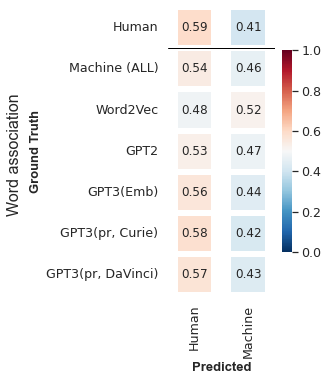

mean
[0.5249999761581421, 0.5549999475479126, 0.5299999713897705, 0.5149999856948853, 0.5049999952316284, 0.5099999904632568]
std
[0.01133876746978135, 0.030715707632034343, 0.02925213667409613, 0.029949494962100424, 0.02597522858271275, 0.03156825200976424]
['word2vec', 'gpt2', 'gpt3 (embedding)', 'gpt3 (prompt curie)', 'gpt3 (prompt davinvci)']
bootstraptime 1000 sampletime 500
bootstraptime 200 sampletime 100
bootstraptime 200 sampletime 100
bootstraptime 200 sampletime 100
bootstraptime 200 sampletime 100
bootstraptime 200 sampletime 100


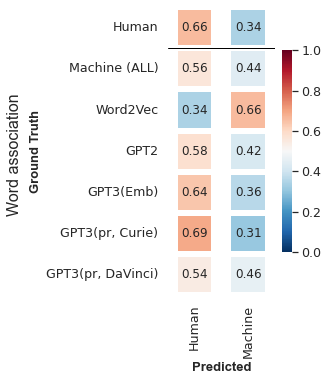

mean
[0.550000011920929, 0.6600000262260437, 0.5400000214576721, 0.5099999904632568, 0.48500001430511475, 0.5600000023841858]
std
[0.011072487299608868, 0.027773008479457177, 0.028293097656495646, 0.028331784271379744, 0.027161910370958824, 0.0293938662819303]
['word2vec', 'gpt2', 'gpt3 (embedding)', 'gpt3 (prompt curie)', 'gpt3 (prompt davinvci)']
bootstraptime 2000 sampletime 1000
bootstraptime 400 sampletime 200
bootstraptime 400 sampletime 200
bootstraptime 400 sampletime 200
bootstraptime 400 sampletime 200
bootstraptime 400 sampletime 200


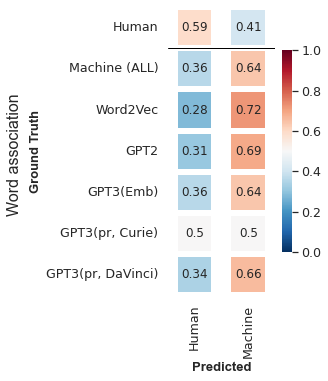

mean
[0.6150000095367432, 0.6549999713897705, 0.6399999856948853, 0.6150000095367432, 0.5449999570846558, 0.625]
std
[0.007604099535776729, 0.019699078936272634, 0.021031760766457477, 0.019985697034066635, 0.020898518749842058, 0.01955750735012005]
['word2vec', 'gpt2', 'gpt3 (embedding)', 'gpt3 (prompt curie)', 'gpt3 (prompt davinvci)']
bootstraptime 750 sampletime 375
bootstraptime 150 sampletime 75
bootstraptime 150 sampletime 75
bootstraptime 150 sampletime 75
bootstraptime 150 sampletime 75
bootstraptime 150 sampletime 75


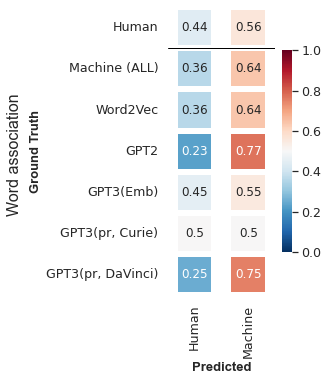

mean
[0.5399999618530273, 0.5399999618530273, 0.6050000190734863, 0.4950000047683716, 0.4699999988079071, 0.5950000286102295]
std
[0.012882890128929693, 0.03503578417617488, 0.03724327762690955, 0.036488753552327176, 0.03490021047727399, 0.03282877388910113]


In [ ]:
import pandas as pd
import os
from matplotlib import font_manager as fm, rcParams
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

sn.set(font_scale=1.15)
rcParams['font.size'] = 12
fpath_arial = "/home/liuxiao/Downloads/arial/ARIAL.TTF"
fpath_arialbold =  "/home/liuxiao/Downloads/arial/ARIALBD.TTF"
prop_arial = fm.FontProperties(fname=fpath_arial)
prop_arialbold = fm.FontProperties(fname=fpath_arialbold)
def plot_res_demographics_singleplot(condition_chosen, TextFilePath, condition_results, folderpath, saveflag):

    top1, top1std, result_conf_mat, dummy = ComputeBarStdConfMat(condition_results[condition_chosen])


    modelname_dict = {'Human':'Human','M':'M','Machine':'Machine (ALL)','word2vec':'Word2Vec','gpt2':'GPT2','gpt3 (embedding)':'GPT3(Emb)', 'gpt3emb':'GPT3(Emb)','gpt3 (prompt curie)':'GPT3(pr, Curie)','gpt3promptcurie':'GPT3(pr, Curie)','gpt3 (prompt davinvci)':'GPT3(pr, DaVinci)','gpt3promptdav':'GPT3(pr, DaVinci)'}
    modelname_dict_2 = {v:v for k,v in modelname_dict.items()}
    modelname_dict = {**modelname_dict, **modelname_dict_2}
    modelist = ['Human', 'Machine', 'word2vec', 'gpt2', 'gpt3 (embedding)', 'gpt3 (prompt curie)', 'gpt3 (prompt davinvci)']
    modelist = [modelname_dict[_] for _ in modelist]

    df_cm = pd.DataFrame(result_conf_mat, index = [i for i in modelist],
                  columns = [i for i in ['Human','Machine']])
    plt.figure(figsize = (2.4,5.3))

    if condition_chosen == 'machine':
        ax = sn.heatmap(df_cm, annot=True,robust=True, cmap='RdBu_r', vmin=0, vmax=1, cbar=False,annot_kws={'ha':'center'})#, annot_kws={"fontsize":8})
    else:
#         # change location of colorbar
#         axins = inset_axes(
#         plt.gca(),
#         width="5%",  # width: 5% of parent_bbox width
#         height="50%",  # height: 50%
#         loc="upper left",
#         bbox_to_anchor=(1.05, 0., 1, 1),
#         bbox_transform=plt.gca().transAxes,
#         borderpad=0,
#         )
        ax = sn.heatmap(df_cm, annot=True,robust=True, cmap='RdBu_r', vmin=0, vmax=1, cbar=True, annot_kws={'ha':'center'}, cbar_kws={"shrink":0.7})#, "ticks":['0','0.2','0.4','0.6','0.8','1']})#, annot_kws={"fontsize":12})




    for i in range(df_cm.shape[0] + 1):
        ax.axhline(i, color='white', lw=6)
    for i in range(df_cm.shape[1] + 1):
        ax.axvline(i, color='white', lw=20)

    _=ax.axhline(1, color='black', lw=1)
#     print(help(_))
    plt.xlabel("Predicted",weight='bold',fontproperties=prop_arialbold,fontsize=13)
    _ = plt.ylabel("Ground Truth",weight='bold', fontproperties=prop_arialbold,fontsize=13)
    plt.text(-3,5, "Word association",fontproperties=prop_arial,fontsize=16,rotation=90)
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation = 90,ha='center')
#     ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, va='center')
#     plt.yticks(range(len(modelist)),modelist, va='center')
#     ax.set_yticks(np.arange(data.shape[0]) + 0.5)





    plotname = condition_chosen
    plt.savefig(folderpath + plotname + '_overall_confmat.eps', format='eps', bbox_inches='tight')
    plt.savefig(folderpath + plotname + '_overall_confmat.png', bbox_inches='tight')
    plt.savefig(XIAOROOT + plotname + '_overall_confmat.pdf', bbox_inches='tight')
    plt.savefig(XIAOROOT + plotname + '_overall_confmat.eps', format='eps', bbox_inches='tight')
    plt.show()

    if saveflag == 1:
        np.save(TextFilePath + "confmat.np", result_conf_mat)

    #data
    #x-axis
#     years = list(range(1, len(modelist)-1))
#     strtask = modelist[1:]
#     #print(years)
#     #print(strtask)

#     # Figure Size
#     fig, ax = plt.subplots()

#     ax.add_patch(Rectangle((-0.5, 0.45), len(modelist)-1, 0.1,facecolor='yellow'))
#     #bar chart properties
#     #ax.bar(strtask, top1, color ='black', width = 0.3)
#     ax.bar(strtask, top1, yerr=top1std,
#        align='center', alpha=0.5, ecolor='black', capsize=10,
#        color ='black', width = 0.3)

    print('mean')
    print(top1)
    print('std')
    print(top1std)

#     plt.ylabel('Top-1 Accuracy')
#     plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees

#     plt.ylim(0.3, 1)
#     #plt.xlim(0.5, len(years)+0.5)

#     #draw chance 0.5
#     chancex =np.arange(len(years)+1)
#     plt.plot(chancex, np.arange(len(chancex))*0+0.5, 'k--', label='chance (50%)')
#     #plt.legend()

#     fig.tight_layout()

#     fig.set_figwidth(3.5)
#     fig.set_figheight(5)

#     #fig.legend(loc='upper center', bbox_to_anchor=(0.55, 1.0), ncol=3, fancybox=True, shadow=True,frameon=False)

#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)

#     plt.savefig(folderpath + plotname + '_overall_barplot.eps', format='eps', bbox_inches='tight')
#     plt.savefig(folderpath + plotname + '_overall_barplot.png', bbox_inches='tight')
#     plt.savefig(XIAOROOT + plotname + '_overall_barplot.pdf', bbox_inches='tight')
#     plt.show()



#======================Plot overall results (human judges)=======
calculation_type = 'rebuttal_allresults' # exclude training samples when gather human results
keep_catch_trials = False
with open("./savedResults/compiled_feedback_{}.json".format(calculation_type), 'r') as f:
    CompiledResults = json.load(f)

#======================Plot overall results (human judges with feedback)=======
key = 'mturk' #choose from these choices: inlab, mturk-feedback
TextFilePath = './savedResults/Task2_' + key + '_' #not being used
folderpath = './plots/Task2_' + key + '_' #for saving the plots
saveflag = 1 #save confmat for final plots
plot_res_demographics_singleplot(key, TextFilePath, CompiledResults, folderpath, saveflag)

#======================Plot overall results (human judges with feedback)=======
key = 'mturk-feedback' #choose from these choices: inlab, mturk-feedback
TextFilePath = './savedResults/Task2_' + key + '_' #not being used
folderpath = './plots/Task2_' + key + '_' #for saving the plots
saveflag = 1 #save confmat for final plots
plot_res_demographics_singleplot(key, TextFilePath, CompiledResults, folderpath, saveflag)

# #======================Plot overall results (human judges without feedback)=======
# key = 'mturk' #choose from these choices: inlab, mturk
# TextFilePath = './savedResults/Task1_' + key + '_' #not being used
# folderpath = './plots/Task1_' + key + '_' #for saving the plots
# saveflag = 0 #save confmat for final plots
# plot_res_demographics_singleplot(key, TextFilePath, CompiledResults, folderpath, saveflag)

#======================Plot overall results (AI judges feedback)=======
with open("./savedResults/compiled_feedback_{}.json".format(calculation_type), 'r') as f:
    CompiledResults = json.load(f)

key = 'machine-feedback' #choose from these choices: inlab, mturk
TextFilePath = './savedResults/Task2_' + key + '_' #not being used
folderpath = './plots/Task2_' + key + '_' #for saving the plots
saveflag = 1
plot_res_demographics_singleplot(key, TextFilePath, CompiledResults, folderpath, saveflag)

#======================Plot overall results (AI judges zeroshot)=======
with open("./savedResults/compiled_feedback_{}.json".format(calculation_type), 'r') as f:
    CompiledResults = json.load(f)

key = 'machine-zeroshot' #choose from these choices: inlab, mturk
TextFilePath = './savedResults/Task2_' + key + '_' #not being used
folderpath = './plots/Task2_' + key + '_' #for saving the plots
saveflag = 1
plot_res_demographics_singleplot(key, TextFilePath, CompiledResults, folderpath, saveflag)

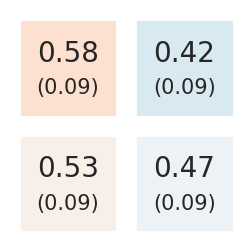

['word2vec', 'gpt2', 'gpt3 (embedding)', 'gpt3 (prompt curie)', 'gpt3 (prompt davinvci)']
nTrials: machine (ALL): 750  Word2Vec: 150  GPT2: 150  GPT3(Emb): 150  GPT3(pr, Curie): 150  GPT3(pr, DaVinci): 150  
bootstraptime 750 sampletime 375
bootstraptime 150 sampletime 75
bootstraptime 150 sampletime 75
bootstraptime 150 sampletime 75
bootstraptime 150 sampletime 75
bootstraptime 150 sampletime 75
[1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1

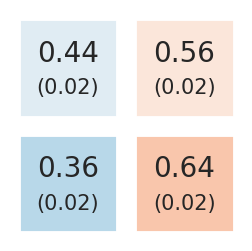

['word2vec', 'gpt2', 'gpt3 (embedding)', 'gpt3 (prompt curie)', 'gpt3 (prompt davinvci)']
nTrials: machine (ALL): 1000  Word2Vec: 200  GPT2: 200  GPT3(Emb): 200  GPT3(pr, Curie): 200  GPT3(pr, DaVinci): 200  
bootstraptime 1000 sampletime 500
bootstraptime 200 sampletime 100
bootstraptime 200 sampletime 100
bootstraptime 200 sampletime 100
bootstraptime 200 sampletime 100
bootstraptime 200 sampletime 100
[0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

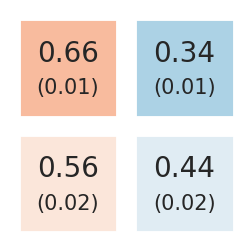

['word2vec', 'gpt2', 'gpt3 (embedding)', 'gpt3 (prompt curie)', 'gpt3 (prompt davinvci)']
nTrials: machine (ALL): 2000  Word2Vec: 400  GPT2: 400  GPT3(Emb): 400  GPT3(pr, Curie): 400  GPT3(pr, DaVinci): 400  
bootstraptime 2000 sampletime 1000
bootstraptime 400 sampletime 200
bootstraptime 400 sampletime 200
bootstraptime 400 sampletime 200
bootstraptime 400 sampletime 200
bootstraptime 400 sampletime 200
[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,

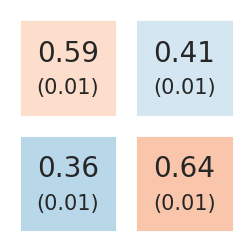

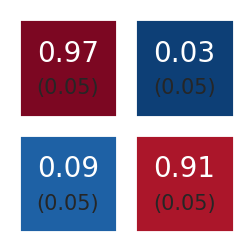

In [4]:
import pandas as pd
import os
from matplotlib import font_manager as fm, rcParams
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

sn.set(font_scale=1.15)
rcParams['font.size'] = 20
fpath_arial = "/content/drive/MyDrive/arial/ARIAL.TTF"
fpath_arialbold =  "/content/drive/MyDrive/arial/ARIALBD.TTF"
prop_arial = fm.FontProperties(fname=fpath_arial)
prop_arialbold = fm.FontProperties(fname=fpath_arialbold)

def plot_res_demographics_singleplot(condition_chosen, TextFilePath, condition_results, folderpath, saveflag):
    if condition_chosen not in ['mturk','machine']:
      top1, top1std, result_conf_mat, dummy, results = ComputeBarStdConfMat(condition_results[condition_chosen])


      print(results['result_M'])
      modelist = ['Human', 'Machine (ALL)']
      df_cm = pd.DataFrame(result_conf_mat[:2], index = [i for i in modelist],
                    columns = [i for i in ['Human','Machine']])
      h_std = round(np.std(results['result_H'])/(len(results['result_H'])**0.5),2)
      m_std = round(np.std(results['result_M'])/(len(results['result_M'])**0.5),2)
      stds = np.array([[h_std,h_std],[m_std,m_std]])
    elif condition_chosen == 'machine':
      modelist = ['Human', 'Machine (ALL)']
      result_conf_mat = np.array([[0.97,0.03],[0.09,0.91]])
      df_cm = pd.DataFrame(result_conf_mat, index = [i for i in modelist],
                    columns = [i for i in ['Human','Machine']])
      stds = np.array([[0.05,0.05],[0.05,0.05]])
    else:
      modelist = ['Human', 'Machine (ALL)']
      result_conf_mat = np.array([[0.58,0.42],[0.53,0.47]])
      df_cm = pd.DataFrame(result_conf_mat, index = [i for i in modelist],
                    columns = [i for i in ['Human','Machine']])
      stds = np.array([[0.09,0.09],[0.09,0.09]])

    plt.figure(figsize = (3,3))
    # text = np.array([ ])
    if condition_chosen == 'machine':
        ax = sn.heatmap(df_cm, annot=True,robust=True, cmap='RdBu_r', vmin=0, vmax=1, cbar=False,annot_kws={'ha':'center','va':'bottom'})#, annot_kws={"fontsize":8})
    else:
#         # change location of colorbar
#         axins = inset_axes(
#         plt.gca(),
#         width="5%",  # width: 5% of parent_bbox width
#         height="50%",  # height: 50%
#         loc="upper left",
#         bbox_to_anchor=(1.05, 0., 1, 1),
#         bbox_transform=plt.gca().transAxes,
#         borderpad=0,
#         )
        ax = sn.heatmap(df_cm, annot=True,robust=True, cmap='RdBu_r', vmin=0, vmax=1, cbar=False, annot_kws={'ha':'center','va':'bottom'}, cbar_kws={"shrink":0.7})#, "ticks":['0','0.2','0.4','0.6','0.8','1']})#, annot_kws={"fontsize":12})

    ax.tick_params(left=False, bottom=False)
    ax.set_yticklabels([])
    ax.set_xticklabels([])

    for i in range(df_cm.shape[0] + 1):
        ax.axhline(i, color='white', lw=15)
    for i in range(df_cm.shape[1] + 1):
        ax.axvline(i, color='white', lw=15)

    voffset = 0.23
    hoffset = -0.27

    for i in range(2):
      for j in range(2):
        plt.text(0.5+j*1+hoffset,0.5+i*1+voffset,'({})'.format(stds[i,j]),fontsize=15)
#     _=ax.axhline(1, color='black', lw=1)
# #     print(help(_))
#     plt.xlabel("Predicted",weight='bold',fontproperties=prop_arialbold,fontsize=13)
#     _ = plt.ylabel("Ground Truth",weight='bold', fontproperties=prop_arialbold,fontsize=13)
#     plt.text(-2.5,5.2, "Image captioning",fontproperties=prop_arial,fontsize=16,rotation=90)
#     _ = ax.set_xticklabels(ax.get_xticklabels(), rotation = 90,ha='center')
#     ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, va='center')
#     plt.yticks(range(len(modelist)),modelist, va='center')
#     ax.set_yticks(np.arange(data.shape[0]) + 0.5)





    plotname = condition_chosen
    # plt.savefig(folderpath + plotname + '_overall_confmat.eps', format='eps', bbox_inches='tight')
    # plt.savefig(folderpath + plotname + '_overall_confmat.png', bbox_inches='tight')
    # plt.savefig(XIAOROOT + plotname + '_overall_confmat.pdf', bbox_inches='tight')
    # plt.savefig(XIAOROOT + plotname + '_overall_confmat.eps', format='eps', bbox_inches='tight')

    plt.savefig(ROOT+'/Plot/plots/' + plotname + '_2x2overall.eps', format='eps', bbox_inches='tight')
    plt.savefig(ROOT+'/Plot/plots/' + plotname + '_2x2overall.pdf', bbox_inches='tight')

    plt.show()

    # if saveflag == 1:
    #     np.save(TextFilePath + "confmat.np", result_conf_mat)


        #data
    #x-axis
    # years = list(range(1, len(modelist)-1))
    # strtask = modelist[1:]
    #print(years)
    #print(strtask)

#     # Figure Size
#     fig, ax = plt.subplots()

#     ax.add_patch(Rectangle((-0.5, 0.45), len(modelist)-1, 0.1,facecolor='yellow'))
#     #bar chart properties
#     #ax.bar(strtask, top1, color ='black', width = 0.3)
#     ax.bar(strtask, top1, yerr=top1std,
#        align='center', alpha=0.5, ecolor='black', capsize=10,
#        color ='black', width = 0.3)

    # print('mean')
    # print(top1)
    # print('std')
    # print(top1std)

#     plt.ylabel('Top-1 Accuracy')
#     plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees

#     plt.ylim(0.3, 1)
#     #plt.xlim(0.5, len(years)+0.5)

#     #draw chance 0.5
#     chancex =np.arange(len(years)+1)
#     plt.plot(chancex, np.arange(len(chancex))*0+0.5, 'k--', label='chance (50%)')
#     #plt.legend()

#     fig.tight_layout()

#     fig.set_figwidth(3.5)
#     fig.set_figheight(5)

#     #fig.legend(loc='upper center', bbox_to_anchor=(0.55, 1.0), ncol=3, fancybox=True, shadow=True,frameon=False)

#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)

#     plt.savefig(folderpath + plotname + '_overall_barplot.eps', format='eps', bbox_inches='tight')
#     plt.savefig(folderpath + plotname + '_overall_barplot.png', bbox_inches='tight')
#     plt.savefig(XIAOROOT + plotname + '_overall_barplot.pdf', bbox_inches='tight')
#     plt.show()



#======================Plot overall results (human judges)=======
calculation_type = 'rebuttal_allresults' # exclude training samples when gather human results
keep_catch_trials = False
with open(ROOT+"/Plot/savedResults/compiled_feedback_{}.json".format(calculation_type), 'r') as f:
    CompiledResults = json.load(f)
#======================Plot overall results (human judges)=======
key = 'mturk' #choose from these choices: inlab, mturk-feedback
TextFilePath = ROOT+'/Plot/savedResults/Task1_' + key + '_' #not being used
folderpath = ROOT+'/Plot/plots/Task1_' + key + '_' #for saving the plots
saveflag = 1 #save confmat for final plots
plot_res_demographics_singleplot(key, TextFilePath, CompiledResults, folderpath, saveflag)

#======================Plot overall results (AI judges zeroshot)=======
with open(ROOT+"/Plot/savedResults/compiled_feedback_{}.json".format(calculation_type), 'r') as f:
    CompiledResults = json.load(f)

key = 'machine-zeroshot' #choose from these choices: inlab, mturk
TextFilePath = './savedResults/Task1_' + key + '_' #not being used
folderpath = './plots/Task1_' + key + '_' #for saving the plots
saveflag = 1
plot_res_demographics_singleplot(key, TextFilePath, CompiledResults, folderpath, saveflag)

#======================Plot overall results (human judges with feedback)=======
key = 'mturk-feedback' #choose from these choices: inlab, mturk-feedback
TextFilePath = ROOT+'/Plot/savedResults/Task1_' + key + '_' #not being used
folderpath = ROOT+'/Plot/plots/Task1_' + key + '_' #for saving the plots
saveflag = 1 #save confmat for final plots
plot_res_demographics_singleplot(key, TextFilePath, CompiledResults, folderpath, saveflag)

# #======================Plot overall results (human judges without feedback)=======
# key = 'mturk' #choose from these choices: inlab, mturk
# TextFilePath = './savedResults/Task1_' + key + '_' #not being used
# folderpath = './plots/Task1_' + key + '_' #for saving the plots
# saveflag = 0 #save confmat for final plots
# plot_res_demographics_singleplot(key, TextFilePath, CompiledResults, folderpath, saveflag)

#======================Plot overall results (AI judges feedback)=======
with open(ROOT+"/Plot/savedResults/compiled_feedback_{}.json".format(calculation_type), 'r') as f:
    CompiledResults = json.load(f)

key = 'machine-feedback' #choose from these choices: inlab, mturk
TextFilePath = ROOT+'/Plot/savedResults/Task1_' + key + '_' #not being used
folderpath = ROOT+'/Plot/plots/Task1_' + key + '_' #for saving the plots
saveflag = 1
plot_res_demographics_singleplot(key, TextFilePath, CompiledResults, folderpath, saveflag)

#======================Plot overall results (AI judges feedback)=======
with open(ROOT+"/Plot/savedResults/compiled_feedback_{}.json".format(calculation_type), 'r') as f:
    CompiledResults = json.load(f)

key = 'machine' #choose from these choices: inlab, mturk
TextFilePath = ROOT+'/Plot/savedResults/Task1_' + key + '_' #not being used
folderpath = ROOT+'/Plot/plots/Task1_' + key + '_' #for saving the plots
saveflag = 1
plot_res_demographics_singleplot(key, TextFilePath, CompiledResults, folderpath, saveflag)

